In [2]:
# importing packages
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from google.cloud import bigquery

In [3]:
# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "openaq" dataset
dataset_ref = client.dataset("thelook_ecommerce", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# List all the tables in the "thelook_ecommerce" dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset
for table in tables:  
    print(table.table_id)

Using Kaggle's public dataset BigQuery integration.
distribution_centers
events
inventory_items
order_items
orders
products
users


In [4]:
# get schema of all tables to undertand how they relate to each other and whihc info each one contains
for table in tables:
    table_ref = dataset_ref.table(table.table_id)
    # API request - fetch the table
    table = client.get_table(table_ref)
    # Print the table name
    print(f"\nSchema for table: {table.table_id}")
    print("-" * 50)  # Separator for readability
    
    # Print each field in the schema in a human-readable format
    for field in table.schema:
        print(f"Column: {field.name}")
        print(f"  Type: {field.field_type}")
        print(f"  Mode: {field.mode}")
        if field.description:
            print(f"  Description: {field.description}")
        print()  # Blank line for separation between fields


Schema for table: distribution_centers
--------------------------------------------------
Column: id
  Type: INTEGER
  Mode: NULLABLE

Column: name
  Type: STRING
  Mode: NULLABLE

Column: latitude
  Type: FLOAT
  Mode: NULLABLE

Column: longitude
  Type: FLOAT
  Mode: NULLABLE

Column: distribution_center_geom
  Type: GEOGRAPHY
  Mode: NULLABLE


Schema for table: events
--------------------------------------------------
Column: id
  Type: INTEGER
  Mode: NULLABLE

Column: user_id
  Type: INTEGER
  Mode: NULLABLE

Column: sequence_number
  Type: INTEGER
  Mode: NULLABLE

Column: session_id
  Type: STRING
  Mode: NULLABLE

Column: created_at
  Type: TIMESTAMP
  Mode: NULLABLE

Column: ip_address
  Type: STRING
  Mode: NULLABLE

Column: city
  Type: STRING
  Mode: NULLABLE

Column: state
  Type: STRING
  Mode: NULLABLE

Column: postal_code
  Type: STRING
  Mode: NULLABLE

Column: browser
  Type: STRING
  Mode: NULLABLE

Column: traffic_source
  Type: STRING
  Mode: NULLABLE

Column: ur

In [5]:
# get first five rows of all tables
for table in tables:
    table_ref = dataset_ref.table(table.table_id)
    # API request - fetch the table
    table = client.get_table(table_ref)
    # Preview the first five lines of all tables
    print(f"\nTable: {table.table_id}")
    print(client.list_rows(table, max_results=5).to_dataframe())
    


Table: distribution_centers
   id                                         name  latitude  longitude  \
0   9                                Charleston SC   32.7833   -79.9333   
1   6  Port Authority of New York/New Jersey NY/NJ   40.6340   -73.7834   
2   2                                   Chicago IL   41.8369   -87.6847   
3  10                                  Savannah GA   32.0167   -81.1167   
4   1                                   Memphis TN   35.1174   -89.9711   

  distribution_center_geom  
0  POINT(-79.9333 32.7833)  
1   POINT(-73.7834 40.634)  
2  POINT(-87.6847 41.8369)  
3  POINT(-81.1167 32.0167)  
4  POINT(-89.9711 35.1174)  

Table: events
        id  user_id  sequence_number                            session_id  \
0  2038247      NaN                3  f7221be2-a713-44d8-8a31-ce736717a5bb   
1  2401900      NaN                3  d40ee200-2abd-4f9a-b3f6-052ecbd06a34   
2  1587221      NaN                3  070098a8-2420-4138-8b39-14b7fcef5ad7   
3  1912005      NaN

In [6]:
query = """
    SELECT o.order_id, o.num_of_item, oi.*, 
    p.name AS product_name, p.cost AS product_cost, p.retail_price, p.category, p.brand,
    u.created_at AS user_created_at, u.country AS user_country
    FROM `bigquery-public-data.thelook_ecommerce.order_items` oi
    LEFT JOIN `bigquery-public-data.thelook_ecommerce.orders` o ON (oi.order_id = o.order_id)
    LEFT JOIN `bigquery-public-data.thelook_ecommerce.products` p ON (oi.product_id = p.id)
    LEFT JOIN `bigquery-public-data.thelook_ecommerce.users` u ON (oi.user_id = u.id);"""

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
first_query_job = client.query(query)

# API request - run the query, and return a pandas DataFrame
complete_orders_df = first_query_job.to_dataframe()

# View top few rows of results
print(complete_orders_df.head())

   order_id  num_of_item      id  order_id_1  user_id  product_id  \
0    116028            2  168262      116028    92880       14235   
1    119097            4  172708      119097    95333       14235   
2     93353            2  135312       93353    74637       14235   
3    107550            3  155881      107550    86140       14235   
4    102493            1  148550      102493    82070       14235   

   inventory_item_id      status                created_at  \
0             454386   Cancelled 2024-01-09 23:40:46+00:00   
1             466502   Cancelled 2023-05-12 00:05:48+00:00   
2             365339    Complete 2024-10-10 14:36:47+00:00   
3             420929    Complete 2024-12-05 11:35:54+00:00   
4             401028  Processing 2023-08-20 12:12:00+00:00   

                 shipped_at              delivered_at returned_at  sale_price  \
0                       NaT                       NaT         NaT        0.02   
1                       NaT                       

In [7]:
# checking if the data came out correctly
def get_df_info(df):
    """
    df: pandas dataframe
    output: summary of info about the dataframe
    """
    # column names and datatypes
    info = df.info()
    
    # show duplicate rows
    duplicated_rows = df[df.duplicated()]

    # null values
    null_values = df.isnull().sum()
    
    # Return results as a dictionary
    return {
        "column_names and datatypes": info,
        "duplicated_rows": duplicated_rows,
        "null_values": null_values
    }

# operation to remove duplicate order_id_1 column of final dataset
if 'order_id_1' in complete_orders_df.columns:
    if complete_orders_df['order_id'].equals(complete_orders_df['order_id_1']):# columns are the same, therefore deleting the second occurence
        complete_orders_df.drop('order_id_1', axis =1, inplace = True)
# # operation to remove sale_price if it is the same as retail_price
if 'sale_price' in complete_orders_df.columns:
    if complete_orders_df['sale_price'].equals(complete_orders_df['retail_price']):
        complete_orders_df.drop('sale_price', axis =1, inplace = True)

# adding a column for month/year of purchase
complete_orders_df['month_year'] = complete_orders_df['created_at'].dt.to_period('M').dt.to_timestamp()

# range of purchases is from 01/2019 to 12/2024
complete_orders_df['month_year'].min()
complete_orders_df['month_year'].max()

# adding a column to record if the order was returned
complete_orders_df['was_returned'] = np.where(complete_orders_df['status'] == 'Returned', 1, 0)

get_df_info(complete_orders_df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181190 entries, 0 to 181189
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   order_id           181190 non-null  int64              
 1   num_of_item        181190 non-null  int64              
 2   id                 181190 non-null  int64              
 3   user_id            181190 non-null  int64              
 4   product_id         181190 non-null  int64              
 5   inventory_item_id  181190 non-null  int64              
 6   status             181190 non-null  object             
 7   created_at         181190 non-null  datetime64[us, UTC]
 8   shipped_at         117971 non-null  datetime64[us, UTC]
 9   delivered_at       63211 non-null   datetime64[us, UTC]
 10  returned_at        17783 non-null   datetime64[us, UTC]
 11  product_name       181179 non-null  object             
 12  product_cost       181190 non-

/tmp/ipykernel_24/2985389381.py:33: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  complete_orders_df['month_year'] = complete_orders_df['created_at'].dt.to_period('M').dt.to_timestamp()


{'column_names and datatypes': None,
 'duplicated_rows': Empty DataFrame
 Columns: [order_id, num_of_item, id, user_id, product_id, inventory_item_id, status, created_at, shipped_at, delivered_at, returned_at, product_name, product_cost, retail_price, category, brand, user_created_at, user_country, month_year, was_returned]
 Index: [],
 'null_values': order_id                  0
 num_of_item               0
 id                        0
 user_id                   0
 product_id                0
 inventory_item_id         0
 status                    0
 created_at                0
 shipped_at            63219
 delivered_at         117979
 returned_at          163407
 product_name             11
 product_cost              0
 retail_price              0
 category                  0
 brand                   165
 user_created_at           0
 user_country              0
 month_year                0
 was_returned              0
 dtype: int64}

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

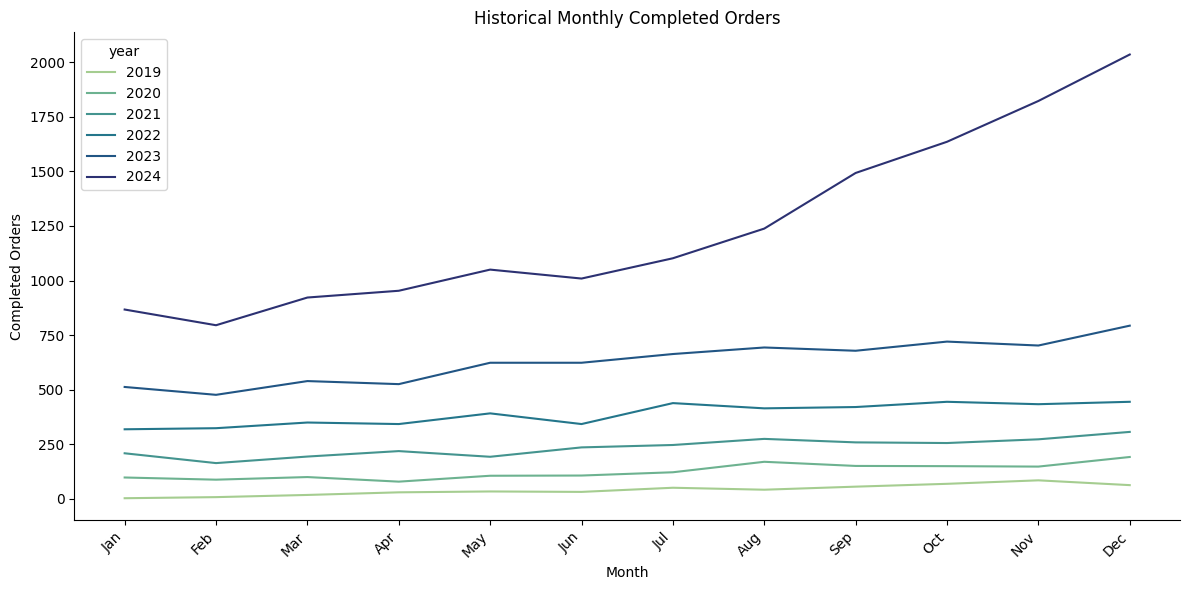

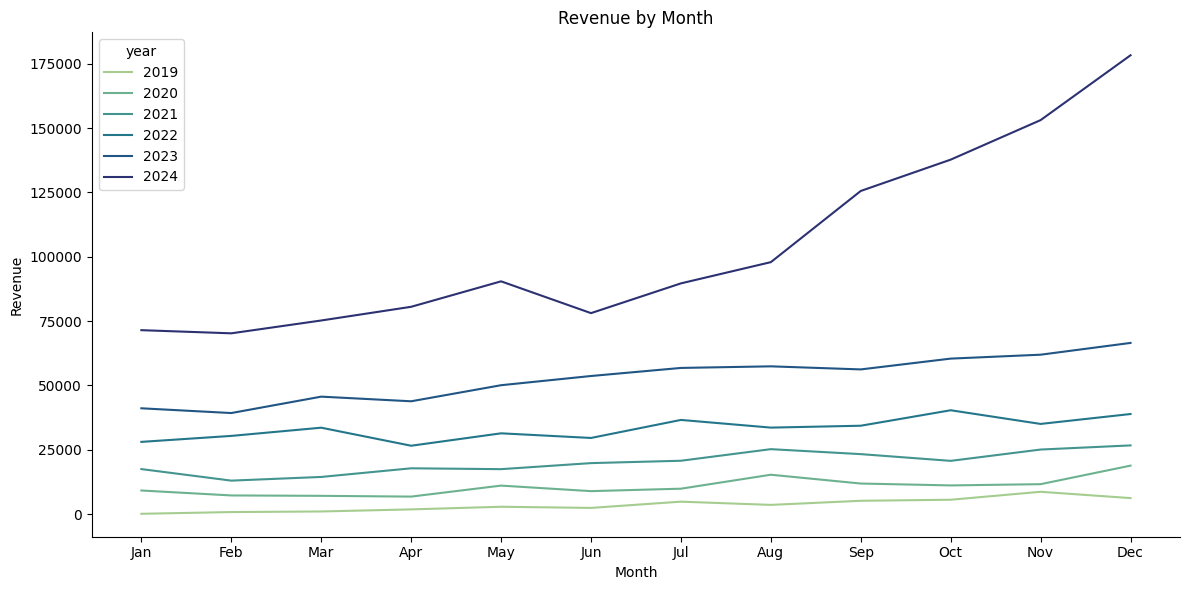

In [8]:
# first analysis of sales: number of completed orders per month 

# removing cancelled, processing and shipped
finalized_orders_df = complete_orders_df[~complete_orders_df['status'].isin(['Cancelled', 'Processing', 'Shipped'])]

# getting list of order_id where 'was_returned' == 1
returned_order_ids = finalized_orders_df.loc[finalized_orders_df['was_returned'] == 1, 'order_id'].tolist()

# removing order_id that came up in the list
only_complete_order_ids_df = finalized_orders_df[~finalized_orders_df['order_id'].isin(returned_order_ids)]

# group by month_year and count unique order_id 
monthly_orders_count = only_complete_order_ids_df.groupby('month_year')['order_id'].nunique().reset_index()
monthly_orders_count.columns = ['month_year', 'completed_orders']
monthly_orders_count['month_year'] = pd.to_datetime(monthly_orders_count['month_year'])
monthly_orders_count['year'] = monthly_orders_count['month_year'].dt.year
monthly_orders_count['month'] = monthly_orders_count['month_year'].dt.month

# plotting the results
plt.figure(figsize = (12, 6))
sns.lineplot(data = monthly_orders_count, x = 'month', y = 'completed_orders', hue = 'year', palette = 'crest')
plt.title('Historical Monthly Completed Orders')
plt.xlabel('Month')
plt.ylabel('Completed Orders')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xticks(rotation = 45, ha = 'right')
sns.despine()
plt.tight_layout()
plt.savefig('completed_orders_2019-2024.png', dpi=300)

# second analysis of sales: revenue per month
monthly_revenue = only_complete_order_ids_df.groupby('month_year')['retail_price'].sum().reset_index()
monthly_revenue.columns = ['month_year', 'total_revenue']
monthly_revenue['month_year'] = pd.to_datetime(monthly_revenue['month_year'])
monthly_revenue['year'] = monthly_revenue['month_year'].dt.year
monthly_revenue['month'] = monthly_revenue['month_year'].dt.month

# plotting revenue per month
plt.figure(figsize = (12, 6))
sns.lineplot(data = monthly_revenue, x = 'month', y = 'total_revenue', hue = 'year', palette = 'crest')
plt.title('Revenue by Month')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
sns.despine()
plt.tight_layout()
plt.savefig('revenue_2019-2024.png', dpi=300)


In [9]:
print(monthly_orders_count.sort_values(by = 'completed_orders', ascending= False))
print(monthly_revenue.sort_values(by = 'total_revenue', ascending= False))

# calculating revenue per year
yearly_revenue = monthly_revenue.groupby('year')['total_revenue'].sum()
print(yearly_revenue)

# total order per year
yearly_orders = only_complete_order_ids_df.drop_duplicates(subset='order_id') \
    .groupby('year')['order_id'].count()

print(yearly_orders)

   month_year  completed_orders  year  month
71 2024-12-01              2036  2024     12
70 2024-11-01              1823  2024     11
69 2024-10-01              1636  2024     10
68 2024-09-01              1493  2024      9
67 2024-08-01              1238  2024      8
..        ...               ...   ...    ...
5  2019-06-01                31  2019      6
3  2019-04-01                29  2019      4
2  2019-03-01                17  2019      3
1  2019-02-01                 7  2019      2
0  2019-01-01                 2  2019      1

[72 rows x 4 columns]
   month_year  total_revenue  year  month
71 2024-12-01  178324.560251  2024     12
70 2024-11-01  153121.310212  2024     11
69 2024-10-01  137752.590168  2024     10
68 2024-09-01  125580.780107  2024      9
67 2024-08-01   97906.590029  2024      8
..        ...            ...   ...    ...
5  2019-06-01    2380.540000  2019      6
3  2019-04-01    1807.289998  2019      4
2  2019-03-01     997.350001  2019      3
1  2019-02-01    

KeyError: 'year'

In [ ]:
current_revenue = yearly_revenue[2024]
previous_revenue = yearly_revenue[2023]

revenue_increase = ((current_revenue - previous_revenue) / previous_revenue) * 100

order_n_increase = ((14663 - 7410)/ 7410) * 100

In [ ]:
only_complete_order_ids_df['month_year'] = pd.to_datetime(only_complete_order_ids_df['month_year'])
only_complete_order_ids_df.dtypes


In [ ]:
# average order value per year
# creating a copy
only_complete_order_ids_df = only_complete_order_ids_df.copy()
# modifying dataframe to add year info
only_complete_order_ids_df.loc[:, 'year'] = only_complete_order_ids_df['month_year'].dt.year
# calculating total order value
only_complete_order_ids_df.loc[:, 'total_order_value'] = only_complete_order_ids_df.groupby('order_id')['retail_price'].transform('sum')
average_order_per_year = only_complete_order_ids_df.groupby('year')['total_order_value'].mean().reset_index()
print(average_order_per_year) # order value has not changed much per year, so the increased 
#revenue is due to the increased order frequency and number of orders

In [ ]:
# first analysis of products: which products are most often purchased and the revenue they bring in
only_complete_order_ids_df.head(5)
# creating columns for month and year separately
only_complete_order_ids_df.loc[:, 'month_year'] = pd.to_datetime(only_complete_order_ids_df['month_year'])
only_complete_order_ids_df['year'] = only_complete_order_ids_df['month_year'].dt.year  
only_complete_order_ids_df['month'] = only_complete_order_ids_df['month_year'].dt.month  


# grouping and aggregation
product_summary = (
    only_complete_order_ids_df
    .groupby(['product_name', 'year'], as_index=False)  # Group by product_name and year
    .agg(
        total_revenue=('retail_price', 'sum'),        # Total revenue (sum of retail prices)
        total_cost=('product_cost', 'sum')           # Total cost
    )
)

# sorting the summary for easier analysis
product_summary = product_summary.sort_values(by=['year', 'total_revenue'], ascending=[True, False])

# getting the top 10 most profitable products per year
top_products_per_year = (
    product_summary
    .groupby('year', group_keys=False)
    .apply(lambda group: group.nlargest(5, 'total_revenue'))  # Select top 5
)

# creating a table from the top products per year
print(top_products_per_year.round(1).to_string(index=False))

# category popularity
most_popular_item_categories = (
    only_complete_order_ids_df['category']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'category', 'category': 'count'})
)
print(most_popular_item_categories)

print(only_complete_order_ids_df['category'].size)

most_popular_item_categories_per_year = (
    only_complete_order_ids_df
    .groupby('year')['category']
    .value_counts()
    .reset_index(name='count')  # Properly name the count column
)

print(most_popular_item_categories_per_year[most_popular_item_categories_per_year['year'].isin([2023, 2024])]
)



In [ ]:
# calculating revenue per category
revenue_category = (
    only_complete_order_ids_df
    .groupby(['category', 'year'], as_index=False)  # group by category and year
    .agg(
        total_revenue=('retail_price', 'sum'),        
        total_cost=('product_cost', 'sum'),
    )
)
revenue_category['profit_margin'] = (revenue_category['total_revenue'] - revenue_category['total_cost'])/ revenue_category['total_revenue']*100 
print((
    revenue_category[revenue_category['year'].isin([2023, 2024])]
    .sort_values(by=['year', 'total_revenue', 'profit_margin'], ascending=[False, False, False])
))

print(revenue_category['profit_margin'].mean())

# calculating average price per item in top categories
item_price_per_category = (
    only_complete_order_ids_df
    .groupby(['category'], as_index= False)
    .agg(
        avg_price=('retail_price', 'mean')
    )
)
print(item_price_per_category)

In [ ]:
only_complete_order_ids_df.head()

In [ ]:
sales_per_category_and_year= (
    only_complete_order_ids_df
    .groupby(['year', 'category'])
    .agg(
        total_revenue=('retail_price', 'sum'),  # Total revenue (sum of retail prices)
        total_cost=('product_cost', 'sum'),  # Total cost
        total_items= ('category', 'count')# Total items per category
     ).round(1)
    .sort_values(by=['year', 'total_revenue'], ascending=[True, False])
    .groupby('year').head(5)  # Selecting top 5 categories per year
)

print(sales_per_category_and_year)

In [ ]:
# first customer analysis: how many new customers were obtained per month in 2024?

# sorting the dataframe by customer_id
only_complete_order_ids_df.sort_values(by = 'user_id', inplace = True)
# creating a column that shows whether it was a customer's first purchase or not (repeating customer)
only_complete_order_ids_df['was_first_order'] = np.where(
    only_complete_order_ids_df['created_at'] == 
    only_complete_order_ids_df.groupby('user_id')['created_at'].transform('min'),
    1,
    0
)
# group data per year, count occurences of was_first_order == 1 to obtain number 
# of new customers per year
new_customers_per_year = (
    only_complete_order_ids_df[only_complete_order_ids_df['was_first_order'] == 1]
    .groupby('year')['was_first_order']
    .count()
    .reset_index()  # making it a df
    .rename(columns={'was_first_order': 'yearly_new_customers'})  # renaming column
)
print(new_customers_per_year)
#splitting the data to obtain only 2024 orders
complete_orders_2024 = only_complete_order_ids_df[only_complete_order_ids_df['year'] == 2024]
new_customers_per_month = (     
    complete_orders_2024[complete_orders_2024['was_first_order'] == 1]
    .groupby('month')['was_first_order']
    .count()
    .reset_index()  # making it a df
    .rename(columns={'was_first_order': 'monthly_new_customers'})  # renaming column
)
print(new_customers_per_month)

unique_customers_2024 = complete_orders_2024['user_id'].nunique()
unique_customers_all_time = only_complete_order_ids_df['user_id'].nunique()

print(f"Unique customers in 2024: {unique_customers_2024}")
print(f"Unique customers all time: {unique_customers_all_time}")

In [ ]:
plt.figure(figsize = (12, 6))
sns.lineplot(data = new_customers_per_month, x= 'month', y= 'monthly_new_customers', color = 'darkblue')
plt.title('Customer Acquisition in 2024')
plt.xlabel('Month')
plt.ylabel('New Customers')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
sns.despine()
plt.tight_layout()
plt.savefig('newCustomersPerMothPlot.png', dpi=300)


In [ ]:
# checking percentage of users that return to make at least a second purchase
unique_purchases = only_complete_order_ids_df[['user_id', 'order_id']].drop_duplicates()

# unique purchase events per user
user_purchase_counts = unique_purchases.groupby('user_id')['order_id'].nunique()

# recurring customers 
recurring_customers = user_purchase_counts[user_purchase_counts > 1].count()

# total number of unique customers
total_unique_customers = user_purchase_counts.count()

# percentage of recurring customers
percentage_recurring_customers = (recurring_customers / total_unique_customers) * 100

# Print the result
print(f"Percentage of recurring customers: {percentage_recurring_customers:.2f}%")
print(total_unique_customers)

In [ ]:
print(user_purchase_counts.sort_values(ascending= False))